# Capstone Project - The Battle of Neighborhoods (Atlanta) 

### Purpose of this notebook:

Whippit Coffee Shop, a hypothetical coffee shop, is in the process of establishing a new franchise location in within the Midtown neighborhood of the city of Atlanta, Georgia. Midtown is a busy commercial area and is also a vibrant arts hub. The High Museum of Art shows world-renowned works in a striking modern building, while Margaret Mitchell House offers tours of the former home of the “Gone With the Wind” author. The owners want an analysis of the existing crime rates in Midtown and any existing competitors.  

To accomplish this an analysis of both: 
    1. Neighborhood Crime Rates
    and 
    2. Existing coffee shops and ratings
    
Our target is to present an accurate representation of criminal activies within the Midtown neighboorhood, and perform a comparitive analysis of likely competitor coffee shops.

### Data sources

The crime data comes from "https://data.world/bryantahb/crime-in-atlanta-2009-2017".

The competitor information will be provided via a Foursquare venue exploration.

### First we will import all of the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import io 

#Command to install OpenCage Geocoder for fetching Lat and Lng of Neighborhood
!pip install opencage

#Importing OpenCage Geocoder
from opencage.geocoder import OpenCageGeocode

# use the inline backend to generate the plots within the browser
%matplotlib inline 

#Importing Matplot lib and associated packages to perform Data Visualisation and Exploratory Data Analysis
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#Importing folium to visualise Maps and plot based on Lat and Lng
!conda install -c conda-forge folium=0.5.0 --yes
import folium

#Requests to request web pages by making get requests to FourSquare REST Client
import requests

#To normalise data returned by FourSquare API
from pandas.io.json import json_normalize

#Importing KMeans from SciKit library to Classify neighborhoods into clusters
from sklearn.cluster import KMeans

print('Libraries imported')

Matplotlib version:  3.0.2
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    ---------------------------------------------------------

### Load the dataset.

In [2]:
source_df = pd.read_csv('https://query.data.world/s/wn6axfgzrlazee2sjsx4abwx6qb7io')

source_df.head(10)

/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Unnamed: 0                 crime     number        date  \
0           0   LARCENY-NON VEHICLE  103040029  10/31/2010   
1           1            AUTO THEFT  103040061  10/31/2010   
2           2  LARCENY-FROM VEHICLE  103040169  10/31/2010   
3           3            AUTO THEFT  103040174  10/31/2010   
4           4   LARCENY-NON VEHICLE  103040301  10/31/2010   
5           5    BURGLARY-RESIDENCE  103040333  10/31/2010   
6           6    ROBBERY-PEDESTRIAN  103040345  10/31/2010   
7           7   LARCENY-NON VEHICLE  103040385  10/31/2010   
8           8  LARCENY-FROM VEHICLE  103040387  10/31/2010   
9           9  LARCENY-FROM VEHICLE  103040412  10/31/2010   

                                  location beat               neighborhood  \
0                         610 SPRING ST NW  509                   Downtown   
1                            850 OAK ST SW  401                   West End   
2                1344 METROPOLITAN PKWY SW  301         Capitol View Manor   
3                         1752 PRYOR RD SW  307             Betmar LaVilla   
4  JOHN WESLEY DOBBS AVE NE / CORLEY ST NE  604            Old Fourth Ward   
5                       430 W WESLEY RD NW  205  Peachtree Battle Alliance   
6                     MYRTLE DR @ PLAZA LN  410           Campbellton Road   
7                        1980 DELOWE DR SW  410           Campbellton Road   
8                      506 MORELAND AVE SE  201                    Brandon   
9                      229 PEACHTREE ST NE  509                   Downtown   

  npu       lat      long  
0   M  33.77101 -84.38895  
1   T  33.74057 -84.41680  
2   X  33.71803 -84.40774  
3   Y  33.70731 -84.39674  
4   M  33.75947 -84.36626  
5   C  33.82838 -84.40133  
6   R  33.70537 -84.45498  
7   R  33.70121 -84.45724  
8   C  33.83193 -84.42627  
9   M  33.76040 -84.38746

In [3]:
source_df.shape

(270688, 10)

### Let start cleaning up the data for our purposes. The dataset is quite large so we will only work on data for the year of 2017, since this is the most recent year of the dataset. 

In [4]:
df_crime_2017 = source_df[source_df['date'].str.contains("2017")]
df_crime_2017.head(10)

Unnamed: 0                 crime     number        date  \
60057       60057  LARCENY-FROM VEHICLE  170310137  01/31/2017   
60058       60058   LARCENY-NON VEHICLE  170310233  01/31/2017   
60059       60059            AUTO THEFT  170310259  01/31/2017   
60060       60060  LARCENY-FROM VEHICLE  170310558  01/31/2017   
60061       60061            AUTO THEFT  170310627  01/31/2017   
60062       60062            AUTO THEFT  170310687  01/31/2017   
60063       60063    ROBBERY-COMMERCIAL  170310719  01/31/2017   
60064       60064  LARCENY-FROM VEHICLE  170310743  01/31/2017   
60065       60065    BURGLARY-RESIDENCE  170310842  01/31/2017   
60066       60066       BURGLARY-NONRES  170310888  01/31/2017   

                            location beat       neighborhood npu       lat  \
60057                19 SPRING LN NW  105          West Lake   J  33.75560   
60058            2452 MOROSGO WAY NE  211  Lindbergh/Morosgo   B  33.82295   
60059                39 BOOKER ST NW  105    Washington Park   K  33.75588   
60060               554 LAWTON ST SW  401           West End   T  33.73999   
60061  1829 CAMPBELLTON RD SW         408     Venetian Hills   S  33.71954   
60062            3157 MCMURRAY DR SW  409          Southwest   R  33.70496   
60063           3639 PEACHTREE RD NE  210     Ridgedale Park   B  33.85373   
60064             54 PEACHTREE ST SW  511           Downtown   M  33.75286   
60065          154 CANDLELIGHT LN SW  407        Baker Hills   H  33.75858   
60066          420 MCDONOUGH BLVD SE  305     Chosewood Park   Y  33.71436   

           long  
60057 -84.43856  
60058 -84.36559  
60059 -84.42019  
60060 -84.42315  
60061 -84.44871  
60062 -84.49107  
60063 -84.35777  
60064 -84.39120  
60065 -84.52006  
60066 -84.37410

In [5]:
df_crime_2017.shape

(4007, 10)

In [6]:
df_crime = df_crime_2017.drop(['Unnamed: 0', 'number', 'location', 'beat', 'npu', 'date'], axis=1)


df_crime

crime             neighborhood       lat      long
60057   LARCENY-FROM VEHICLE                West Lake  33.75560 -84.43856
60058    LARCENY-NON VEHICLE        Lindbergh/Morosgo  33.82295 -84.36559
60059             AUTO THEFT          Washington Park  33.75588 -84.42019
60060   LARCENY-FROM VEHICLE                 West End  33.73999 -84.42315
60061             AUTO THEFT           Venetian Hills  33.71954 -84.44871
60062             AUTO THEFT                Southwest  33.70496 -84.49107
60063     ROBBERY-COMMERCIAL           Ridgedale Park  33.85373 -84.35777
60064   LARCENY-FROM VEHICLE                 Downtown  33.75286 -84.39120
60065     BURGLARY-RESIDENCE              Baker Hills  33.75858 -84.52006
60066        BURGLARY-NONRES           Chosewood Park  33.71436 -84.37410
60067     BURGLARY-RESIDENCE             East Atlanta  33.73988 -84.34020
60068             AUTO THEFT                Southwest  33.69730 -84.49142
60069     ROBBERY-PEDESTRIAN          Old Fourth Ward  33.76901 -84.37444
60070   LARCENY-FROM VEHICLE   Morningside/Lenox Park  33.81274 -84.36659
60071    LARCENY-NON VEHICLE                   Bolton  33.81639 -84.46585
60072     BURGLARY-RESIDENCE               Pine Hills  33.84787 -84.35109
60073            AGG ASSAULT           Venetian Hills  33.71714 -84.44365
60074   LARCENY-FROM VEHICLE              Mozley Park  33.75144 -84.44382
60075   LARCENY-FROM VEHICLE                     Mays  33.74174 -84.50285
60076             AUTO THEFT             Garden Hills  33.83036 -84.38646
60077    LARCENY-NON VEHICLE        Lindbergh/Morosgo  33.82403 -84.36328
60078   LARCENY-FROM VEHICLE                      NaN  33.68990 -84.50584
60079   LARCENY-FROM VEHICLE                Vine City  33.75504 -84.41457
60080        BURGLARY-NONRES                  Midtown  33.78588 -84.38448
60081    LARCENY-NON VEHICLE                 West End  33.73969 -84.41828
60082    LARCENY-NON VEHICLE              Atkins Park  33.77404 -84.35226
60083     BURGLARY-RESIDENCE                 Westview  33.74095 -84.43335
60084     ROBBERY-PEDESTRIAN                Brookwood  33.80211 -84.39603
60085   LARCENY-FROM VEHICLE          Underwood Hills  33.80174 -84.42312
60086   LARCENY-FROM VEHICLE         Castleberry Hill  33.75158 -84.39883
...                      ...                      ...       ...       ...
107772  LARCENY-FROM VEHICLE             Reynoldstown  33.75244 -84.35808
107773            AUTO THEFT             Sylvan Hills  33.70260 -84.40777
107774   LARCENY-NON VEHICLE                      NaN  33.81199 -84.39435
107775           AGG ASSAULT  Blair Villa/Poole Creek  33.65697 -84.38717
107776  LARCENY-FROM VEHICLE        South Tuxedo Park  33.85209 -84.38425
107777  LARCENY-FROM VEHICLE             Hammond Park  33.67925 -84.40813
107778   LARCENY-NON VEHICLE           North Buckhead  33.84911 -84.37075
107779   LARCENY-NON VEHICLE                    Lenox  33.84676 -84.36212
107780   LARCENY-NON VEHICLE          Florida Heights  33.75246 -84.46669
107781   LARCENY-NON VEHICLE   Custer/McDonough/Guice  33.71609 -84.34985
107782    BURGLARY-RESIDENCE            Fairburn Mays  33.74510 -84.50858
107783    BURGLARY-RESIDENCE           Mechanicsville  33.73990 -84.40488
107784   LARCENY-NON VEHICLE          Old Fourth Ward  33.77121 -84.36478
107785   LARCENY-NON VEHICLE   Marietta Street Artery  33.77828 -84.40910
107786            AUTO THEFT               Grove Park  33.78337 -84.45670
107787            AUTO THEFT          Washington Park  33.75735 -84.42140
107788   LARCENY-NON VEHICLE             East Atlanta  33.73469 -84.32987
107789   LARCENY-NON VEHICLE               Grant Park  33.73991 -84.35917
107790   LARCENY-NON VEHICLE                  Midtown  33.78399 -84.38073
107791    ROBBERY-PEDESTRIAN          Old Fourth Ward  33.76500 -84.36578
107792           AGG ASSAULT             Reynoldstown  33.75226 -84.35112
107793            AUTO THEFT          Collier Heights  33.77943 -84.48344
107794   LARCENY-NON VEHICL

In [7]:
df_crime_set = df_crime.set_index('neighborhood')

In [8]:
df_crime_set = df_crime.dropna()
df_crime_set

crime             neighborhood       lat      long
60057   LARCENY-FROM VEHICLE                West Lake  33.75560 -84.43856
60058    LARCENY-NON VEHICLE        Lindbergh/Morosgo  33.82295 -84.36559
60059             AUTO THEFT          Washington Park  33.75588 -84.42019
60060   LARCENY-FROM VEHICLE                 West End  33.73999 -84.42315
60061             AUTO THEFT           Venetian Hills  33.71954 -84.44871
60062             AUTO THEFT                Southwest  33.70496 -84.49107
60063     ROBBERY-COMMERCIAL           Ridgedale Park  33.85373 -84.35777
60064   LARCENY-FROM VEHICLE                 Downtown  33.75286 -84.39120
60065     BURGLARY-RESIDENCE              Baker Hills  33.75858 -84.52006
60066        BURGLARY-NONRES           Chosewood Park  33.71436 -84.37410
60067     BURGLARY-RESIDENCE             East Atlanta  33.73988 -84.34020
60068             AUTO THEFT                Southwest  33.69730 -84.49142
60069     ROBBERY-PEDESTRIAN          Old Fourth Ward  33.76901 -84.37444
60070   LARCENY-FROM VEHICLE   Morningside/Lenox Park  33.81274 -84.36659
60071    LARCENY-NON VEHICLE                   Bolton  33.81639 -84.46585
60072     BURGLARY-RESIDENCE               Pine Hills  33.84787 -84.35109
60073            AGG ASSAULT           Venetian Hills  33.71714 -84.44365
60074   LARCENY-FROM VEHICLE              Mozley Park  33.75144 -84.44382
60075   LARCENY-FROM VEHICLE                     Mays  33.74174 -84.50285
60076             AUTO THEFT             Garden Hills  33.83036 -84.38646
60077    LARCENY-NON VEHICLE        Lindbergh/Morosgo  33.82403 -84.36328
60079   LARCENY-FROM VEHICLE                Vine City  33.75504 -84.41457
60080        BURGLARY-NONRES                  Midtown  33.78588 -84.38448
60081    LARCENY-NON VEHICLE                 West End  33.73969 -84.41828
60082    LARCENY-NON VEHICLE              Atkins Park  33.77404 -84.35226
60083     BURGLARY-RESIDENCE                 Westview  33.74095 -84.43335
60084     ROBBERY-PEDESTRIAN                Brookwood  33.80211 -84.39603
60085   LARCENY-FROM VEHICLE          Underwood Hills  33.80174 -84.42312
60086   LARCENY-FROM VEHICLE         Castleberry Hill  33.75158 -84.39883
60087   LARCENY-FROM VEHICLE               Grant Park  33.73991 -84.35917
...                      ...                      ...       ...       ...
107770   LARCENY-NON VEHICLE               Grove Park  33.76590 -84.43319
107771   LARCENY-NON VEHICLE                Vine City  33.75504 -84.41457
107772  LARCENY-FROM VEHICLE             Reynoldstown  33.75244 -84.35808
107773            AUTO THEFT             Sylvan Hills  33.70260 -84.40777
107775           AGG ASSAULT  Blair Villa/Poole Creek  33.65697 -84.38717
107776  LARCENY-FROM VEHICLE        South Tuxedo Park  33.85209 -84.38425
107777  LARCENY-FROM VEHICLE             Hammond Park  33.67925 -84.40813
107778   LARCENY-NON VEHICLE           North Buckhead  33.84911 -84.37075
107779   LARCENY-NON VEHICLE                    Lenox  33.84676 -84.36212
107780   LARCENY-NON VEHICLE          Florida Heights  33.75246 -84.46669
107781   LARCENY-NON VEHICLE   Custer/McDonough/Guice  33.71609 -84.34985
107782    BURGLARY-RESIDENCE            Fairburn Mays  33.74510 -84.50858
107783    BURGLARY-RESIDENCE           Mechanicsville  33.73990 -84.40488
107784   LARCENY-NON VEHICLE          Old Fourth Ward  33.77121 -84.36478
107785   LARCENY-NON VEHICLE   Marietta Street Artery  33.77828 -84.40910
107786            AUTO THEFT               Grove Park  33.78337 -84.45670
107787            AUTO THEFT          Washington Park  33.75735 -84.42140
107788   LARCENY-NON VEHICLE             East Atlanta  33.73469 -84.32987
107789   LARCENY-NON VEHICLE               Grant Park  33.73991 -84.35917
107790   LARCENY-NON VEHICLE                  Midtown  33.78399 -84.38073
107791    ROBBERY-PEDESTRIAN          Old Fourth Ward  33.76500 -84.36578
107792           AGG ASSAULT             Reynoldstown  33.75226 -84.35112
107793            AUTO THEF

In [9]:
df_crime_set.reset_index()


index                 crime             neighborhood       lat  \
0      60057  LARCENY-FROM VEHICLE                West Lake  33.75560   
1      60058   LARCENY-NON VEHICLE        Lindbergh/Morosgo  33.82295   
2      60059            AUTO THEFT          Washington Park  33.75588   
3      60060  LARCENY-FROM VEHICLE                 West End  33.73999   
4      60061            AUTO THEFT           Venetian Hills  33.71954   
5      60062            AUTO THEFT                Southwest  33.70496   
6      60063    ROBBERY-COMMERCIAL           Ridgedale Park  33.85373   
7      60064  LARCENY-FROM VEHICLE                 Downtown  33.75286   
8      60065    BURGLARY-RESIDENCE              Baker Hills  33.75858   
9      60066       BURGLARY-NONRES           Chosewood Park  33.71436   
10     60067    BURGLARY-RESIDENCE             East Atlanta  33.73988   
11     60068            AUTO THEFT                Southwest  33.69730   
12     60069    ROBBERY-PEDESTRIAN          Old Fourth Ward  33.76901   
13     60070  LARCENY-FROM VEHICLE   Morningside/Lenox Park  33.81274   
14     60071   LARCENY-NON VEHICLE                   Bolton  33.81639   
15     60072    BURGLARY-RESIDENCE               Pine Hills  33.84787   
16     60073           AGG ASSAULT           Venetian Hills  33.71714   
17     60074  LARCENY-FROM VEHICLE              Mozley Park  33.75144   
18     60075  LARCENY-FROM VEHICLE                     Mays  33.74174   
19     60076            AUTO THEFT             Garden Hills  33.83036   
20     60077   LARCENY-NON VEHICLE        Lindbergh/Morosgo  33.82403   
21     60079  LARCENY-FROM VEHICLE                Vine City  33.75504   
22     60080       BURGLARY-NONRES                  Midtown  33.78588   
23     60081   LARCENY-NON VEHICLE                 West End  33.73969   
24     60082   LARCENY-NON VEHICLE              Atkins Park  33.77404   
25     60083    BURGLARY-RESIDENCE                 Westview  33.74095   
26     60084    ROBBERY-PEDESTRIAN                Brookwood  33.80211   
27     60085  LARCENY-FROM VEHICLE          Underwood Hills  33.80174   
28     60086  LARCENY-FROM VEHICLE         Castleberry Hill  33.75158   
29     60087  LARCENY-FROM VEHICLE               Grant Park  33.73991   
...      ...                   ...                      ...       ...   
3784  107770   LARCENY-NON VEHICLE               Grove Park  33.76590   
3785  107771   LARCENY-NON VEHICLE                Vine City  33.75504   
3786  107772  LARCENY-FROM VEHICLE             Reynoldstown  33.75244   
3787  107773            AUTO THEFT             Sylvan Hills  33.70260   
3788  107775           AGG ASSAULT  Blair Villa/Poole Creek  33.65697   
3789  107776  LARCENY-FROM VEHICLE        South Tuxedo Park  33.85209   
3790  107777  LARCENY-FROM VEHICLE             Hammond Park  33.67925   
3791  107778   LARCENY-NON VEHICLE           North Buckhead  33.84911   
3792  107779   LARCENY-NON VEHICLE                    Lenox  33.84676   
3793  107780   LARCENY-NON VEHICLE          Florida Heights  33.75246   
3794  107781   LARCENY-NON VEHICLE   Custer/McDonough/Guice  33.71609   
3795  107782    BURGLARY-RESIDENCE            Fairburn Mays  33.74510   
3796  107783    BURGLARY-RESIDENCE           Mechanicsville  33.73990   
3797  107784   LARCENY-NON VEHICLE          Old Fourth Ward  33.77121   
3798  107785   LARCENY-NON VEHICLE   Marietta Street Artery  33.77828   
3799  107786            AUTO THEFT               Grove Park  33.78337   
3800  107787            AUTO THEFT          Washington Park  33.75735   
3801  107788   LARCENY-NON VEHICLE             East Atlanta  33.73469   
3802  107789   LARCENY-NON VEHICLE               Grant Park  33.73991   
3803  107790   LARCENY-NON VEHICLE                  Midtown  33.78399   
3804  107791    ROBBERY-PEDESTRIAN          Old Fourth Ward  33.76500   
3805  107792           AGG ASSAULT             Reynoldstown  33.75226   
3806  107793            AUTO THEFT          Collier Heights  33.7

### Result: According to the dataset, it appears that Midtown has the second highest crime rates, only behind Downtown.

In [10]:
df_crime_set['neighborhood'].value_counts()



Downtown                       256
Midtown                        169
Lindbergh/Morosgo              104
Old Fourth Ward                100
North Buckhead                  90
Home Park                       79
West End                        77
Collier Heights                 71
Mechanicsville                  68
Edgewood                        66
Lenox                           65
Morningside/Lenox Park          63
Greenbriar                      58
Inman Park                      58
Sylvan Hills                    58
East Atlanta                    56
Pittsburgh                      54
Grant Park                      52
Vine City                       51
Virginia Highland               48
Grove Park                      48
Berkeley Park                   47
Campbellton Road                43
Lindridge/Martin Manor          42
Underwood Hills                 42
Lakewood Heights                42
Castleberry Hill                41
Piedmont Heights                41
Southwest           

### I'm interested in seeing what types of crimes are most common in Midtown.

In [11]:
crime_pvt = pd.pivot_table(df_crime_set,
                            
                               index=['neighborhood'],
                               columns=['crime'],
                               aggfunc=len,
                               fill_value=0,
                               margins=True)
crime_pvt

lat                             \
crime                         AGG ASSAULT AUTO THEFT BURGLARY-NONRES   
neighborhood                                                           
Adair Park                              2          5               0   
Adams Park                              1          2               0   
Adamsville                              3          2               1   
Almond Park                             3          1               0   
Amal Heights                            0          1               0   
Ansley Park                             0          1               0   
Ardmore                                 0          0               0   
Argonne Forest                          0          0               0   
Arlington Estates                       0          0               0   
Ashley Courts                           2          1               0   
Ashview Heights                         0          0               0   
Atkins Park                             0          0               0   
Atlanta Industrial Park                 0          1               0   
Atlanta University Center               2          3               0   
Atlantic Station                        0          2               2   
Audobon Forest                          0          0               1   
Audobon Forest West                     0          1               0   
Baker Hills                             1          0               0   
Bankhead                                8          2               0   
Beecher Hills                           1          2               0   
Ben Hill                                0          0               0   
Ben Hill Acres                          0          0               0   
Ben Hill Terrace                        1          1               0   
Benteen Park                            0          1               0   
Berkeley Park                           1          1               2   
Betmar LaVilla                          1          0               0   
Blair Villa/Poole Creek                 1          1               0   
Blandtown                               0          8               0   
Bolton                                  0          3               0   
Boulevard Heights                       0          0               2   
...                                   ...        ...             ...   
Sweet Auburn                            5          9               0   
Sylvan Hills                            9         14               0   
Tampa Park                              0          0               0   
The Villages at Carver                  0          2               0   
The Villages at Castleberry H           0          0               0   
The Villages at East Lake               0          0               0   
Thomasville Heights                     3          3               1   
Tuxedo Park                             0          0               0   
Underwood Hills                         0          5               2   
Venetian Hills                          5          5               0   
Vine City                               9          5               0   
Virginia Highland                       0          2               2   
Washington Park                         2          5               0   
Wesley Battle                           0          0               0   
West End                                5          8               3   
West Highlands                          0          2               0   
West Lake                               2          1               0   
West Manor                              0          0               0   
West Paces Ferry/Northside              0          0               0   
Westminster/Milmar                      0          0               0   
Westover Plantation                     0          1               0   
Westview                                5          7               0   
Westwo

In [12]:
crime_pvt.reset_index(inplace = True)
crime_pvt.columns = crime_pvt.columns.map(''.join)
crime_pvt.rename(columns={'All':'Total'}, inplace=True)

crime_pvt.head()

neighborhood  latAGG ASSAULT  latAUTO THEFT  latBURGLARY-NONRES  \
0    Adair Park               2              5                   0   
1    Adams Park               1              2                   0   
2    Adamsville               3              2                   1   
3   Almond Park               3              1                   0   
4  Amal Heights               0              1                   0   

   latBURGLARY-RESIDENCE  latHOMICIDE  latLARCENY-FROM VEHICLE  \
0                      2            0                        6   
1                      2            0                        3   
2                      0            0                       11   
3                      0            0                        2   
4                      2            0                        2   

   latLARCENY-NON VEHICLE  latRAPE  latROBBERY-COMMERCIAL  ...  \
0                       3        2                      0  ...   
1                       6        1                      0  ...   
2                       3        1                      1  ...   
3                       5        0                      0  ...   
4                       1        0                      0  ...   

   longBURGLARY-NONRES  longBURGLARY-RESIDENCE  longHOMICIDE  \
0                    0                       2             0   
1                    0                       2             0   
2                    1                       0             0   
3                    0                       0             0   
4                    0                       2             0   

   longLARCENY-FROM VEHICLE  longLARCENY-NON VEHICLE  longRAPE  \
0                         6                        3         2   
1                         3                        6         1   
2                        11                        3         1   
3                         2                        5         0   
4                         2                        1         0   

   longROBBERY-COMMERCIAL  longROBBERY-PEDESTRIAN  longROBBERY-RESIDENCE  \
0                       0                       0                      0   
1                       0                       5                      0   
2                       1                       6                      1   
3                       0                       1                      0   
4                       0                       0                      0   

   longAll  
0     20.0  
1     20.0  
2     29.0  
3     12.0  
4      6.0  

[5 rows x 25 columns]

### Let's display the top five neighborhoods and the crime categories that occur, this will include Midtown.

In [13]:
crime_pvt.sort_values(['longAll'], ascending = False, axis = 0, inplace = True )

crime_pvt_top5 = crime_pvt.iloc[1:6]
crime_pvt_top5

neighborhood  latAGG ASSAULT  latAUTO THEFT  latBURGLARY-NONRES  \
63            Downtown              17             13                   4   
117            Midtown               3             20                   7   
107  Lindbergh/Morosgo               0              8                   1   
129    Old Fourth Ward               1              6                   3   
125     North Buckhead               1              8                   5   

     latBURGLARY-RESIDENCE  latHOMICIDE  latLARCENY-FROM VEHICLE  \
63                       4            3                      126   
117                      9            0                       77   
107                     10            0                       24   
129                     11            0                       39   
125                      3            0                       34   

     latLARCENY-NON VEHICLE  latRAPE  latROBBERY-COMMERCIAL  ...  \
63                       74        3                      1  ...   
117                      45        0                      2  ...   
107                      54        1                      0  ...   
129                      29        0                      0  ...   
125                      38        1                      0  ...   

     longBURGLARY-NONRES  longBURGLARY-RESIDENCE  longHOMICIDE  \
63                     4                       4             3   
117                    7                       9             0   
107                    1                      10             0   
129                    3                      11             0   
125                    5                       3             0   

     longLARCENY-FROM VEHICLE  longLARCENY-NON VEHICLE  longRAPE  \
63                        126                       74         3   
117                        77                       45         0   
107                        24                       54         1   
129                        39                       29         0   
125                        34                       38         1   

     longROBBERY-COMMERCIAL  longROBBERY-PEDESTRIAN  longROBBERY-RESIDENCE  \
63                        1                      10                      1   
117                       2                       6                      0   
107                       0                       5                      1   
129                       0                      11                      0   
125                       0                       0                      0   

     longAll  
63     256.0  
117    169.0  
107    104.0  
129    100.0  
125     90.0  

[5 rows x 25 columns]

### Let's visualize where Midtown stands in reference to crime for increased clarity for the owners.

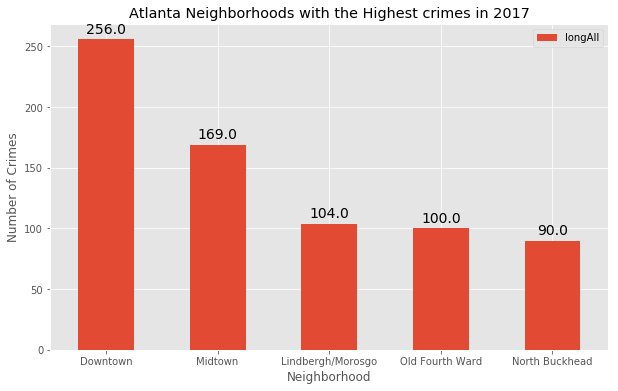

In [14]:
crime_neigh = crime_pvt_top5[['neighborhood','longAll']]

crime_neigh.set_index('neighborhood',inplace = True)

ax = crime_neigh.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Neighborhood')
ax.set_title('Atlanta Neighborhoods with the Highest crimes in 2017')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
               )

plt.show()

In [75]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values


address = "Midtown, Atlanta"

geolocator = Nominatim(user_agent="atlanta_ga_midtown")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Midtown, Georgia are {}, {}.'.format(latitude, longitude))


The geograpical coordinate of Midtown, Georgia are 33.7811275, -84.38636.


### Let's take a look at the distribution of criminal activity within the Midtown neighborhood.

In [78]:
# create map of Toronto using latitude and longitude values
map_atlanta_midtown = folium.Map(location=[latitude, longitude], zoom_start=14)

# add markers to map
for lat, lng, neighborhood, crime in zip(df_crime_set['lat'], df_crime_set['long'], df_crime_set['neighborhood'], df_crime_set['crime']):
    label = '{}, {}'.format(neighborhood, crime)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_atlanta_midtown)  
    
map_atlanta_midtown

### Now let's examine the existing competitors nearby.

In [59]:

CLIENT_ID = 'WIWY4EQFRYUFGFKSL4FZ0NXVROM1OMQPNDFM0IJ3SV0C0U2U' # your Foursquare ID
CLIENT_SECRET = 'QEOMWY5E3WSSRDSA0GXN20ZLU4KL4DERSAQLNISWLJ2WZOKG' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
radius = 1000
#print(search_query + ' .... OK!')

Your credentails:
CLIENT_ID: WIWY4EQFRYUFGFKSL4FZ0NXVROM1OMQPNDFM0IJ3SV0C0U2U
CLIENT_SECRET:QEOMWY5E3WSSRDSA0GXN20ZLU4KL4DERSAQLNISWLJ2WZOKG


In [60]:
neighborhood = "Midtown, GA"

geolocator = Nominatim(user_agent="atlanta_ga_mid")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Midtown, Atlanta, Georgia are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Midtown, Atlanta, Georgia are 33.7490987, -84.3901849.


In [61]:
neighborhood_name = ("Midtown")

neighborhood_latitude = ('33.7833') # neighborhood latitude value
neighborhood_longitude = ('-84.3831') # neighborhood longitude value

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Midtown are 33.7833, -84.3831.


In [62]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

# get the result to a json file
results = requests.get(url).json()

print("Done.")

Done.


In [63]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.id']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

name  \
0                                          Exhale   
1                             Loews Atlanta Hotel   
2                                        Joy Cafe   
3                                            Lure   
4                                      Cafe Agora   
5                              Empire State South   
6                                 Savi Provisions   
7                                      Einstein's   
8                                 Café Intermezzo   
9                                           Tabla   
10              Street Food Thursdays (& Mondays)   
11                         Oceanaire Seafood Room   
12                        Sweet Hut Bakery & Cafe   
13                        The Flying Biscuit Cafe   
14                     Saltwood Charcuterie & Bar   
15                               Joe's on Juniper   
16                        RA Sushi Bar Restaurant   
17                      Willy's Mexicana Grill #8   
18                              Steamhouse Lounge   
19                       Stellar Bodies - Midtown   
20                    Campagnolo Restaurant + Bar   
21                         Henry's Midtown Tavern   
22                            Republic of Couture   
23                       Dancing Goats Coffee Bar   
24                                 Caribou Coffee   
25                              Mac's Beer & Wine   
26                                 Arden's Garden   
27                                   Jason's Deli   
28                        Margaret Mitchell House   
29                                         Eleven   
..                                            ...   
70                          Big Peach Running Co.   
71                                  Establishment   
72                        Flywheel Sports Midtown   
73                             Atwoods Pizza Cafe   
74                                        onlYoga   
75                               Vinny's NY Pizza   
76                            Eleventh Street Pub   
77                                  PONKO Chicken   
78                                      Vibe Ride   
79                                    Rreal Tacos   
80                          Piedmont Driving Club   
81                                McCray's Tavern   
82                      Piedmont Park Active Oval   
83                                      Momo Cafe   
84                               Insomnia Cookies   
85                                   Senor Patron   
86                                    Inserection   
87                                 Fado Irish Pub   
88  Piedmont Park "Noguchi Playscapes" Playground   
89                               J. Christopher's   
90                             Beellagio Nail Bar   
91                                  Hudson Grille   
92                                 CorePower Yoga   
93                                  Kale Me Crazy   
94                              Utrecht/blick Art   
95                                       Momonoki   
96                                11th Street Pub   
97                              Technology Square   
98                  fitinfitout personal training   
99                              DaVinci's Midtown   

                         categories        lat        lng  \
0                               Spa  33.783294 -84.383368   
1                             Hotel  33.783366 -84.383188   
2   Southern / Soul Food Restaurant  33.784921 -84.382922   
3                Seafood Restaurant  33.784972 -84.384408   
4          Mediterranean Restaurant  33.780932 -84.384460   
5   Southern / Soul Food Restaurant  33.781374 -84.383662   
6                      Gourmet Shop  33.781010 -84.384278   
7           New American Restaurant  33.784143 -84.382086   
8                              Café  33.783136 -84.383470   
9                 Indian Restaurant  33.784531 -84.385067   
10                       Food Truck  33.784558 -84.382534   
11               Seafood R

In [64]:
nearby_venues['categories'].value_counts()

American Restaurant                7
Spa                                5
Hotel                              5
Pizza Place                        4
Athletics & Sports                 3
Coffee Shop                        3
Seafood Restaurant                 3
Southern / Soul Food Restaurant    3
Juice Bar                          2
Mediterranean Restaurant           2
Yoga Studio                        2
Lounge                             2
Mexican Restaurant                 2
Gym                                2
Café                               2
Taco Place                         2
Italian Restaurant                 2
Bar                                2
Gym / Fitness Center               2
New American Restaurant            2
Breakfast Spot                     2
Grocery Store                      2
Japanese Restaurant                1
Nail Salon                         1
Bakery                             1
Modern European Restaurant         1
Burrito Place                      1
F

In [65]:
df_venues_coffee = nearby_venues[nearby_venues['categories'].str.contains("Coffee")]
df_venues_coffee.head(10)

name   categories        lat        lng  \
23  Dancing Goats Coffee Bar  Coffee Shop  33.780810 -84.386653   
24            Caribou Coffee  Coffee Shop  33.782122 -84.380645   
49         Starbucks Reserve  Coffee Shop  33.778309 -84.384070   

                          id  
23  588e77fc5e7896466a8dc683  
24  4a030291f964a52079711fe3  
49  572b3747cd105068db04c740

### Our examination shows that there are 3 competitor coffee shops nearby. Next we will take a look at their competitor's ratings to get a decent sense of possible customer loyalties. 

#### Dancing Goats Coffee Bar

In [24]:
venue_id = '588e77fc5e7896466a8dc683' # Dancing Goats Coffee Bar
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
url

'https://api.foursquare.com/v2/venues/588e77fc5e7896466a8dc683?client_id=WIWY4EQFRYUFGFKSL4FZ0NXVROM1OMQPNDFM0IJ3SV0C0U2U&client_secret=QEOMWY5E3WSSRDSA0GXN20ZLU4KL4DERSAQLNISWLJ2WZOKG&v=20180604'

In [25]:
result = requests.get(url).json()
print(result['response']['venue'].keys())
result['response']['venue']

dict_keys(['id', 'name', 'contact', 'location', 'canonicalUrl', 'categories', 'verified', 'stats', 'price', 'likes', 'dislike', 'ok', 'rating', 'ratingColor', 'ratingSignals', 'allowMenuUrlEdit', 'beenHere', 'specials', 'photos', 'reasons', 'hereNow', 'createdAt', 'tips', 'shortUrl', 'timeZone', 'listed', 'hours', 'popular', 'seasonalHours', 'defaultHours', 'pageUpdates', 'inbox', 'attributes', 'bestPhoto', 'colors'])


{'id': '588e77fc5e7896466a8dc683',
 'name': 'Dancing Goats Coffee Bar',
 'contact': {},
 'location': {'address': '33 Peachtree PL NE, Suite 9',
  'crossStreet': '10th St',
  'lat': 33.780810471532014,
  'lng': -84.38665300873899,
  'labeledLatLngs': [{'label': 'display',
    'lat': 33.780810471532014,
    'lng': -84.38665300873899}],
  'postalCode': '30309',
  'cc': 'US',
  'neighborhood': 'Midtown',
  'city': 'Atlanta',
  'state': 'GA',
  'country': 'United States',
  'formattedAddress': ['33 Peachtree PL NE, Suite 9 (10th St)',
   'Atlanta, GA 30309',
   'United States']},
 'canonicalUrl': 'https://foursquare.com/v/dancing-goats-coffee-bar/588e77fc5e7896466a8dc683',
 'categories': [{'id': '4bf58dd8d48988d1e0931735',
   'name': 'Coffee Shop',
   'pluralName': 'Coffee Shops',
   'shortName': 'Coffee Shop',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_',
    'suffix': '.png'},
   'primary': True}],
 'verified': False,
 'stats': {'tipCount': 8},
 'price':

In [26]:
try:
    print(result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')
    

8.7


#### Caribou Coffee

In [27]:
venue_id = '4a030291f964a52079711fe3' # Caribou Coffee
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
print(result['response']['venue'].keys())
result['response']['venue']

dict_keys(['id', 'name', 'contact', 'location', 'canonicalUrl', 'categories', 'verified', 'stats', 'url', 'price', 'likes', 'dislike', 'ok', 'rating', 'ratingColor', 'ratingSignals', 'allowMenuUrlEdit', 'beenHere', 'specials', 'photos', 'reasons', 'description', 'storeId', 'page', 'hereNow', 'createdAt', 'tips', 'shortUrl', 'timeZone', 'listed', 'hours', 'popular', 'seasonalHours', 'defaultHours', 'pageUpdates', 'inbox', 'attributes', 'bestPhoto', 'colors'])


{'id': '4a030291f964a52079711fe3',
 'name': 'Caribou Coffee',
 'contact': {'phone': '4048700711',
  'formattedPhone': '(404) 870-0711',
  'twitter': 'cariboucoffee',
  'facebook': '117584441592773',
  'facebookUsername': 'CBOU10thandPiedmont',
  'facebookName': 'Caribou Coffee'},
 'location': {'address': '1000 Piedmont Avenue NE',
  'lat': 33.782122,
  'lng': -84.3806452,
  'labeledLatLngs': [{'label': 'entrance',
    'lat': 33.782089,
    'lng': -84.380609},
   {'label': 'display', 'lat': 33.782122, 'lng': -84.3806452}],
  'postalCode': '30309',
  'cc': 'US',
  'city': 'Atlanta',
  'state': 'GA',
  'country': 'United States',
  'formattedAddress': ['1000 Piedmont Avenue NE',
   'Atlanta, GA 30309',
   'United States']},
 'canonicalUrl': 'https://foursquare.com/v/caribou-coffee/4a030291f964a52079711fe3',
 'categories': [{'id': '4bf58dd8d48988d1e0931735',
   'name': 'Coffee Shop',
   'pluralName': 'Coffee Shops',
   'shortName': 'Coffee Shop',
   'icon': {'prefix': 'https://ss3.4sqi.net

In [28]:
try:
    print(result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

7.9


#### Starbucks Reserve

In [29]:
venue_id = '572b3747cd105068db04c740' # Starbucks Reserve
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
print(result['response']['venue'].keys())
result['response']['venue']

dict_keys(['id', 'name', 'contact', 'location', 'canonicalUrl', 'categories', 'verified', 'stats', 'url', 'price', 'likes', 'dislike', 'ok', 'rating', 'ratingColor', 'ratingSignals', 'allowMenuUrlEdit', 'beenHere', 'specials', 'photos', 'reasons', 'page', 'hereNow', 'createdAt', 'tips', 'shortUrl', 'timeZone', 'listed', 'hours', 'popular', 'seasonalHours', 'defaultHours', 'pageUpdates', 'inbox', 'attributes', 'bestPhoto', 'colors'])


{'id': '572b3747cd105068db04c740',
 'name': 'Starbucks Reserve',
 'contact': {'phone': '4048767466',
  'formattedPhone': '(404) 876-7466',
  'twitter': 'starbucks',
  'facebook': '22092443056',
  'facebookUsername': 'Starbucks',
  'facebookName': 'Starbucks'},
 'location': {'address': '867 Peachtree St NE',
  'crossStreet': 'at 7th St NE',
  'lat': 33.7783086145192,
  'lng': -84.38406950690771,
  'labeledLatLngs': [{'label': 'display',
    'lat': 33.7783086145192,
    'lng': -84.38406950690771}],
  'postalCode': '30308',
  'cc': 'US',
  'city': 'Atlanta',
  'state': 'GA',
  'country': 'United States',
  'formattedAddress': ['867 Peachtree St NE (at 7th St NE)',
   'Atlanta, GA 30308',
   'United States']},
 'canonicalUrl': 'https://foursquare.com/v/starbucks-reserve/572b3747cd105068db04c740',
 'categories': [{'id': '4bf58dd8d48988d1e0931735',
   'name': 'Coffee Shop',
   'pluralName': 'Coffee Shops',
   'shortName': 'Coffee Shop',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categor

In [30]:
try:
    print(result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

8.3


### Result: All of the competitor coffee shops have a rating of about 8.0 and above with "Dancing Goats Coffee Bar" having the highest rating with an 8.7.

### Let's visualize neaby venue locations in Midtown.

In [46]:
nearby_venues.head()

name                       categories        lat        lng  \
0               Exhale                              Spa  33.783294 -84.383368   
1  Loews Atlanta Hotel                            Hotel  33.783366 -84.383188   
2             Joy Cafe  Southern / Soul Food Restaurant  33.784921 -84.382922   
3                 Lure               Seafood Restaurant  33.784972 -84.384408   
4           Cafe Agora         Mediterranean Restaurant  33.780932 -84.384460   

                         id  
0  4c50aec5375c0f476b27b392  
1  4b45e566f964a520e41126e3  
2  57b22225498e70813a35d62a  
3  4e52a5296365d1ea68cdc001  
4  4ff5df23e4b02b97149a3a65

In [47]:
neighborhood_name = ("Midtown Venues")

neighborhood_latitude = ('33.7833') # neighborhood latitude value
neighborhood_longitude = ('-84.3831') # neighborhood longitude value

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Midtown Venues are 33.7833, -84.3831.


In [49]:
map_nearby_venues = folium.Map(location=[latitude, longitude], zoom_start=14)

# add markers to map
for lat, lng, name in zip(nearby_venues['lat'], nearby_venues['lng'], nearby_venues['name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_nearby_venues)  
    
map_nearby_venues

### Let's focus in and visualize the competitor's locations.

In [37]:
df_venues_coffee

name   categories        lat        lng  \
23  Dancing Goats Coffee Bar  Coffee Shop  33.780810 -84.386653   
24            Caribou Coffee  Coffee Shop  33.782122 -84.380645   
49         Starbucks Reserve  Coffee Shop  33.778309 -84.384070   

                          id  
23  588e77fc5e7896466a8dc683  
24  4a030291f964a52079711fe3  
49  572b3747cd105068db04c740

In [42]:
neighborhood_name = ("Midtown Coffee Venue")

neighborhood_latitude = ('33.782122') # neighborhood latitude value
neighborhood_longitude = ('-84.380645') # neighborhood longitude value

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Midtown Coffee Venue are 33.782122, -84.380645.


In [45]:
map_venues_coffee = folium.Map(location=[latitude, longitude], zoom_start=15)

# add markers to map
for lat, lng, name in zip(df_venues_coffee['lat'], df_venues_coffee['lng'], df_venues_coffee['name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_venues_coffee)  
    
map_venues_coffee

### We can observe that the density of the competitor coffee shops is relatively low.

## Discussion:

Whippit Coffee Shop, a hypothetical coffee shop, is in the process of establishing a new franchise location within the Midtown neighborhood of the city of Atlanta, Georgia. To accomplish this an analysis of both neighborhood crime Rates and existing coffee shops and ratings was performed. Our target was to present an accurate representation of criminal activies within the Midtown neighboorhood, and perform a comparitive analysis of likely competitor coffee shops. 

#### Crime Rates: 
An analysis of the dataset "df_source" imported from "https://data.world/bryantahb/crime-in-atlanta-2009-2017" has shown that within 2017, the Midtown neighborhood was second in crime rates with larceny from vehicles being the largest portion of crimes. This may suggest a need for a location with a secured parking lot, possibly with security, to lessen the likelyhood of this affecting customers. If customers feel that they or their property is safe, the will likely stay longer. 

#### Competition: 
Our Foursquare analysis has has identified 3 competitor coffee shops within the Midtown neighborhood. Please see the below dataframe containing the competitor information:

In [74]:
df_venues_coffee.reset_index()

index                      name   categories        lat        lng  \
0     23  Dancing Goats Coffee Bar  Coffee Shop  33.780810 -84.386653   
1     24            Caribou Coffee  Coffee Shop  33.782122 -84.380645   
2     49         Starbucks Reserve  Coffee Shop  33.778309 -84.384070   

                         id  
0  588e77fc5e7896466a8dc683  
1  4a030291f964a52079711fe3  
2  572b3747cd105068db04c740

All of the competitor coffee shops have a rating of about 8.0 and above with "Dancing Goats Coffee Bar" having the highest rating with an 8.7. This can possibly signal that these venues produce high customer satisfaction and thus customer loyalty may be high to those brands. This should be taken into account when choosing the exact location of the new coffee shop. We have mapped the existing coffee shop locations for reference.

## Conclusion: 

We have performed a general analysis of the neighborhood of Midtown in Atlanta, GA and have presented our findings and some of the potential risks that should be considered when choosing a location to establish the franchise. Once the owners have reviewed this analysis and pin pointed an exact location in Midtown, we can further dive into crime concentrations, this is highly recommended. We have included a map plot of criminal activities within the Midtown neighborhood to aid in this process. 